# Prepare GPX File for RGT Magic Road Upload

Use gpxpy for loading GPX File

https://pypi.org/project/gpxpy/

## SRTM Data

https://github.com/tkrajina/srtm.py

Also consider https://gpx-converter.readthedocs.io/en/latest/ for handling GPX data

In [183]:
#!pip install gpxpy --upgrade
#!pip install SRTM.py --upgrade

## Test Data File: Hockenheimring Motor Racing Circuit

This is a track I recorded running a 5k race on 1 November, 2019 using a Garmin Vivoactive 3 watch. The event was the annual Hockenheimringlauf organized by the local triathon club. It even took place in November 2020 under higly restricted pandemic conditions: I did not take pare. With luck, it may take place again normally in 2021.

https://www.asgtria-hockenheim.de/hockenheim-lauf/ 

Wikipedia article on the race track:

https://en.wikipedia.org/wiki/Hockenheimring




In [184]:
import gpxpy
import gpxpy.gpx

# Parsing an existing file:
# -------------------------

gpx_file = open('hockenheimring-magic-road.GPX', 'r')

gpx = gpxpy.parse(gpx_file)

#for track in gpx.tracks:
#    for segment in track.segments:
#        for point in segment.points:
#            pass
           # print('Point at ({0},{1}) -> {2}'.format(point.latitude, point.longitude, point.elevation))

gpx_points = gpx.tracks[0].segments[0].points # There is only one segment in the GPX file

print(gpx_points[0].latitude, gpx_points[0].longitude, gpx_points[0].elevation, gpx_points[0].time)

49.326423928141594 8.566839387640357 101.19999694824219 2019-11-01 08:01:44+00:00


In [185]:
import pandas as pd 

df = pd.DataFrame([[s.latitude, s.longitude, s.elevation, s.time] for s in gpx_points], columns=['latitude', 'longitude', 'elevation', 'time'])

In [186]:
df

,latitude,longitude,elevation,time
0,49.326424,8.566839,101.199997,2019-11-01 08:01:44+00:00
1,49.326458,8.566810,101.199997,2019-11-01 08:01:45+00:00
2,49.326492,8.566784,101.199997,2019-11-01 08:01:46+00:00
3,49.326524,8.566759,101.199997,2019-11-01 08:01:47+00:00
4,49.326555,8.566735,101.199997,2019-11-01 08:01:48+00:00
...,...,...,...,...
1175,49.326286,8.566948,107.199997,2019-11-01 08:21:19+00:00
1176,49.326317,8.566925,107.199997,2019-11-01 08:21:20+00:00
1177,49.326351,8.566902,107.199997,2019-11-01 08:21:21+00:00
1178,49.326384,8.566877,107.199997,2019-11-01 08:21:22+00:00


<AxesSubplot:xlabel='longitude'>

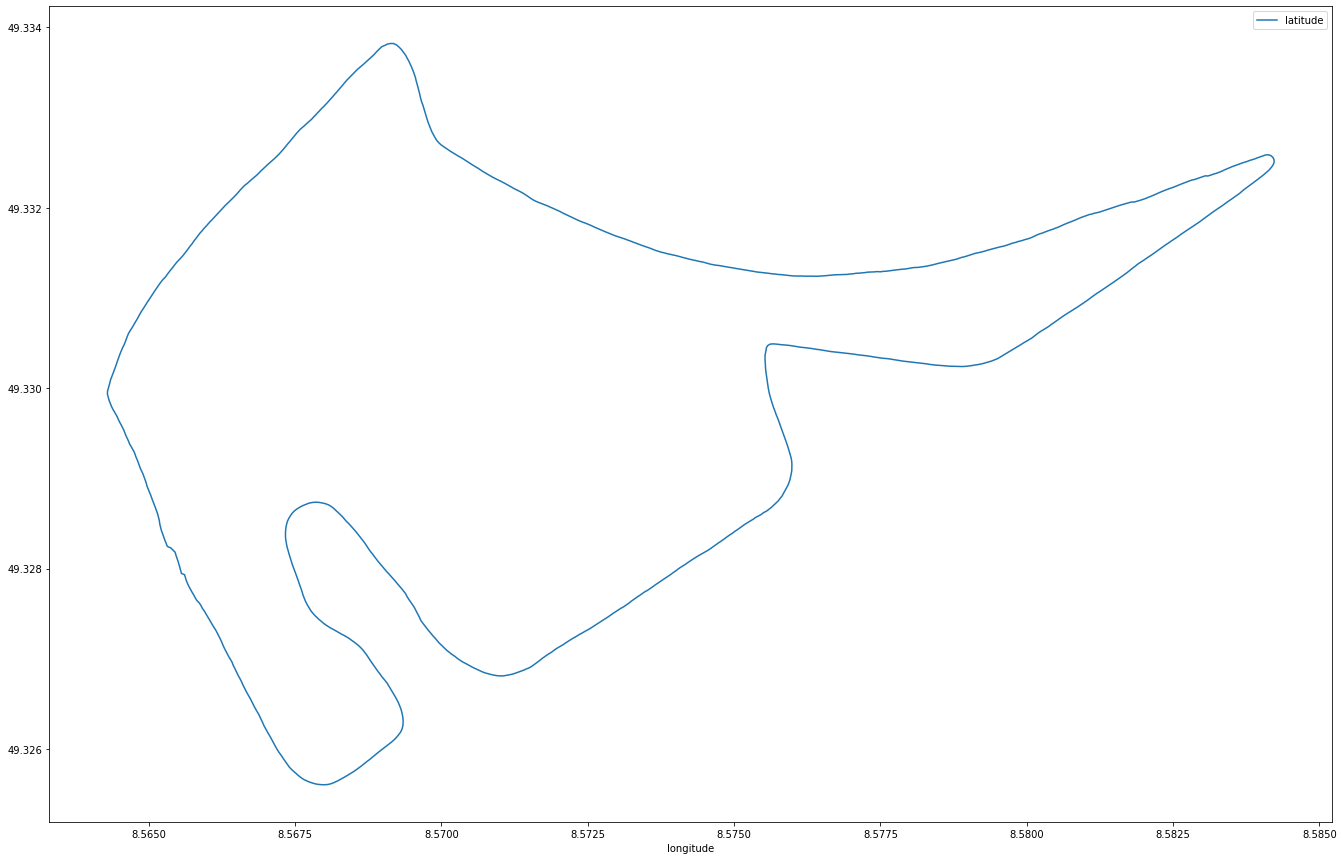

In [187]:
df.plot(x='longitude', y='latitude', figsize=[23, 15])

## Use SRTM data for elevation corrections

Structures on and around the track, such as the spectator stands may cause the SRTM data to be inaccurate

In [188]:
import srtm
elevation_data = srtm.get_data(local_cache_dir="srtmcache") # Cache data so it does not need to be downloaded every time

In [189]:
print(elevation_data.get_elevation(df.iloc[0].latitude, df.iloc[0].longitude))

103


In [190]:
df['srtm_ele'] = df.apply(lambda x: elevation_data.get_elevation(x['latitude'], x['longitude']), axis=1)

In [191]:
elevation_data.add_elevations(gpx, only_missing=False, smooth=True) # See if the built-in elevation function helps

In [192]:
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            pass # doesn't seem to really help
#            print('Point at ({0},{1}) -> {2}'.format(point.latitude, point.longitude, point.elevation))

print(min(pnt.elevation for pnt in gpx.tracks[0].segments[0].points), max(pnt.elevation for pnt in gpx.tracks[0].segments[0].points))

df['srtm_ele_built_in_smooth'] = list(pnt.elevation for pnt in gpx.tracks[0].segments[0].points)
df

100.02891946317384 118.28163227415097


,latitude,longitude,elevation,time,srtm_ele,srtm_ele_built_in_smooth
0,49.326424,8.566839,101.199997,2019-11-01 08:01:44+00:00,103,103.000000
1,49.326458,8.566810,101.199997,2019-11-01 08:01:45+00:00,103,103.214160
2,49.326492,8.566784,101.199997,2019-11-01 08:01:46+00:00,103,103.421182
3,49.326524,8.566759,101.199997,2019-11-01 08:01:47+00:00,103,103.618949
4,49.326555,8.566735,101.199997,2019-11-01 08:01:48+00:00,103,103.808812
...,...,...,...,...,...,...
1175,49.326286,8.566948,107.199997,2019-11-01 08:21:19+00:00,103,103.000000
1176,49.326317,8.566925,107.199997,2019-11-01 08:21:20+00:00,103,103.000000
1177,49.326351,8.566902,107.199997,2019-11-01 08:21:21+00:00,103,103.000000
1178,49.326384,8.566877,107.199997,2019-11-01 08:21:22+00:00,103,103.000000


### Compare Raw SRTM with Original Raw and Both Smoothed

Note the orginal data ends about 5 metres higher than the start point. Presumably this is due to the innacurate barmometric pressure monitor on the Garmin watch. Body heat which rises significantly during the run may account for this.

The RGT magic road processor corrects this on uploaded files. Based on my tests and remembered experience of running the track, the smoothed original data is a better representation of the circuit.

Savitzky-Golay filter seems to do better (see https://stackoverflow.com/a/51841715), https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html 

<AxesSubplot:>

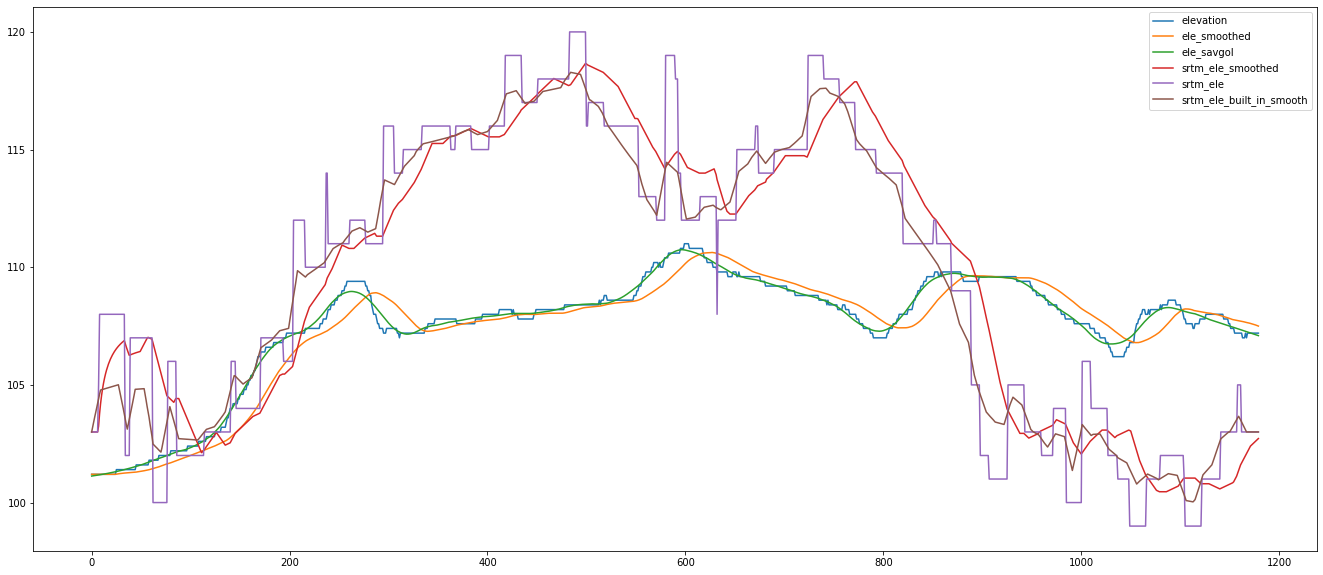

In [193]:
df['srtm_ele_smoothed'] = df['srtm_ele'].rolling(window=50, min_periods=1).mean()
df['ele_smoothed'] = df['elevation'].rolling(window=50, min_periods=1).mean()

from scipy.signal import savgol_filter
df['ele_savgol'] = savgol_filter(df['elevation'], 101, 2)

# Compare original elevation with SRTM, and with both smoothed:
df[['elevation', 'ele_smoothed', 'ele_savgol', 'srtm_ele_smoothed', 'srtm_ele', 'srtm_ele_built_in_smooth']].plot(figsize=[23, 10])

## Todo: Smooth GPS Coordinates

Use Kalman Filter to smooth GPS coordinates: https://stackoverflow.com/questions/48739169/how-to-apply-a-rolling-kalman-filter-to-a-column-in-a-dataframe

* https://stackoverflow.com/questions/43377626/how-to-use-kalman-filter-in-python-for-location-data

* https://stackoverflow.com/questions/52014197/how-to-interpolate-a-2d-curve-in-python

* https://stackoverflow.com/questions/37598986/reducing-noise-on-data 

Have currently settled on savgol filter. Not intended for coordinates but seems to produce reasonable disjoint latitude, longitude smoothing.


In [194]:
from scipy.signal import lfilter
from scipy.interpolate import UnivariateSpline
import scipy

#medfilter = scipy.signal.medfilt2d(df[['latitude', 'longitude']], kernel_size=3)
#medfilter
df[['latitude', 'longitude']]

df_resample = df.resample('5s', on='time').mean()
df_resample

,latitude,longitude,elevation,srtm_ele,srtm_ele_built_in_smooth,srtm_ele_smoothed,ele_smoothed,ele_savgol
time,,,,,,,,
2019-11-01 08:01:40+00:00,49.326424,8.566839,101.199997,103.0,103.000000,103.000000,101.199997,101.126815
2019-11-01 08:01:45+00:00,49.326523,8.566759,101.199997,103.0,103.614335,103.000000,101.199997,101.145158
2019-11-01 08:01:50+00:00,49.326682,8.566629,101.199997,106.4,104.563066,103.754646,101.199997,101.178379
2019-11-01 08:01:55+00:00,49.326832,8.566514,101.199997,108.0,104.829057,105.257527,101.199997,101.215214
2019-11-01 08:02:00+00:00,49.326988,8.566395,101.199997,108.0,104.890411,105.988814,101.199997,101.255663
...,...,...,...,...,...,...,...,...
2019-11-01 08:21:00+00:00,49.325750,8.567478,107.199997,104.2,103.565427,101.248000,107.732000,107.387988
2019-11-01 08:21:05+00:00,49.325896,8.567294,107.079999,103.4,103.341807,101.760000,107.691200,107.318460
2019-11-01 08:21:10+00:00,49.326066,8.567131,107.159998,103.0,103.016565,102.160000,107.644000,107.248631


<AxesSubplot:xlabel='lon_savgol'>

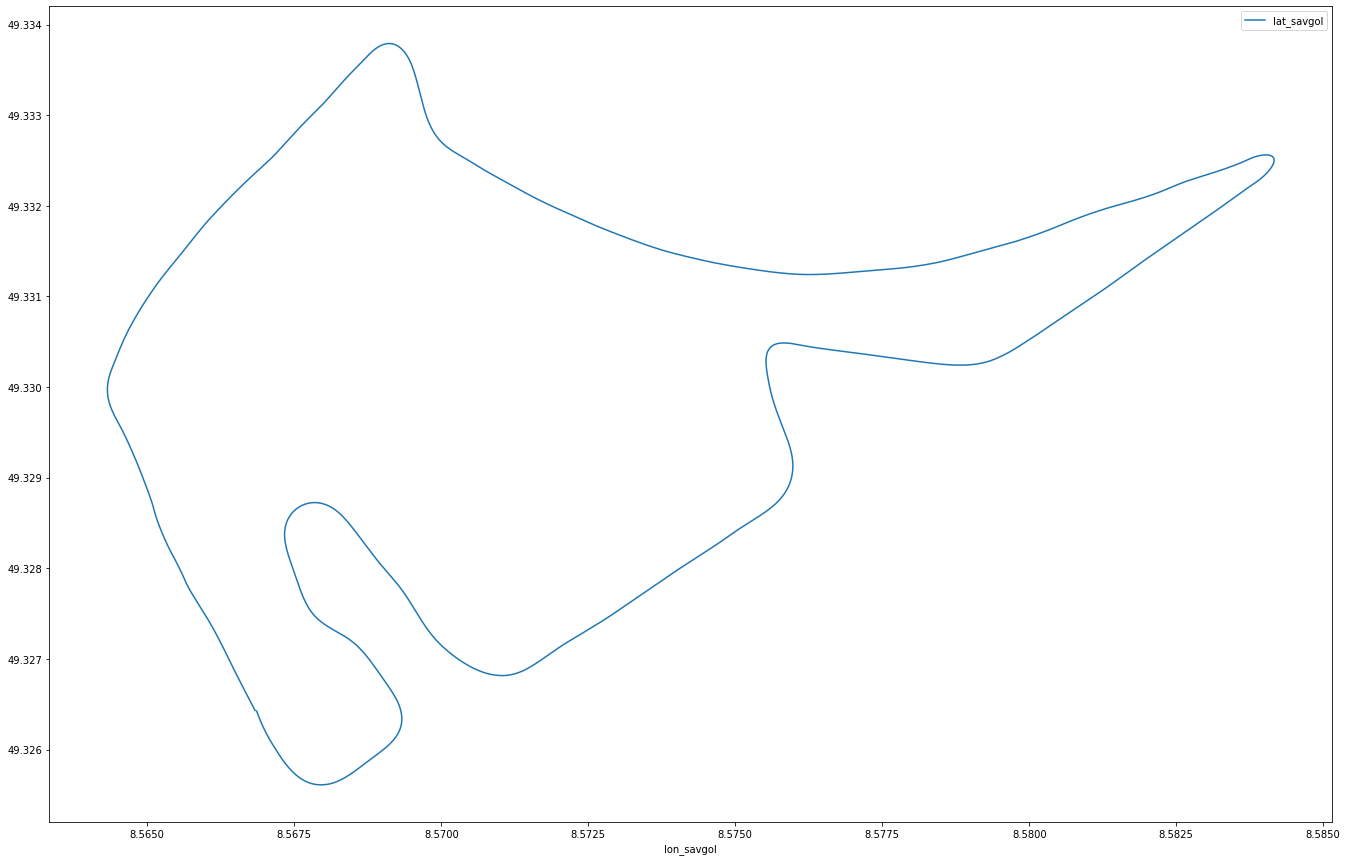

In [195]:
df_upsample = df_resample.resample('1s').interpolate(method='linear', order=5) #.plot(x='longitude', y='latitude', figsize=[23, 15])

df['lat_savgol'] = savgol_filter(df['latitude'], 27, 2)
df['lon_savgol'] = savgol_filter(df['longitude'], 27, 2)
df.plot(x='lon_savgol', y='lat_savgol', figsize=[23, 15])

In [196]:
df

,latitude,longitude,elevation,time,srtm_ele,srtm_ele_built_in_smooth,srtm_ele_smoothed,ele_smoothed,ele_savgol,lat_savgol,lon_savgol
0,49.326424,8.566839,101.199997,2019-11-01 08:01:44+00:00,103,103.000000,103.00,101.199997,101.126815,49.326431,8.566833
1,49.326458,8.566810,101.199997,2019-11-01 08:01:45+00:00,103,103.214160,103.00,101.199997,101.132736,49.326462,8.566808
2,49.326492,8.566784,101.199997,2019-11-01 08:01:46+00:00,103,103.421182,103.00,101.199997,101.138802,49.326492,8.566783
3,49.326524,8.566759,101.199997,2019-11-01 08:01:47+00:00,103,103.618949,103.00,101.199997,101.145013,49.326523,8.566758
4,49.326555,8.566735,101.199997,2019-11-01 08:01:48+00:00,103,103.808812,103.00,101.199997,101.151368,49.326554,8.566733
...,...,...,...,...,...,...,...,...,...,...,...
1175,49.326286,8.566948,107.199997,2019-11-01 08:21:19+00:00,103,103.000000,102.56,107.563999,107.150376,49.326286,8.566944
1176,49.326317,8.566925,107.199997,2019-11-01 08:21:20+00:00,103,103.000000,102.60,107.547999,107.136290,49.326320,8.566922
1177,49.326351,8.566902,107.199997,2019-11-01 08:21:21+00:00,103,103.000000,102.64,107.531999,107.122191,49.326355,8.566900
1178,49.326384,8.566877,107.199997,2019-11-01 08:21:22+00:00,103,103.000000,102.68,107.515999,107.108081,49.326390,8.566879


<AxesSubplot:xlabel='longitude'>

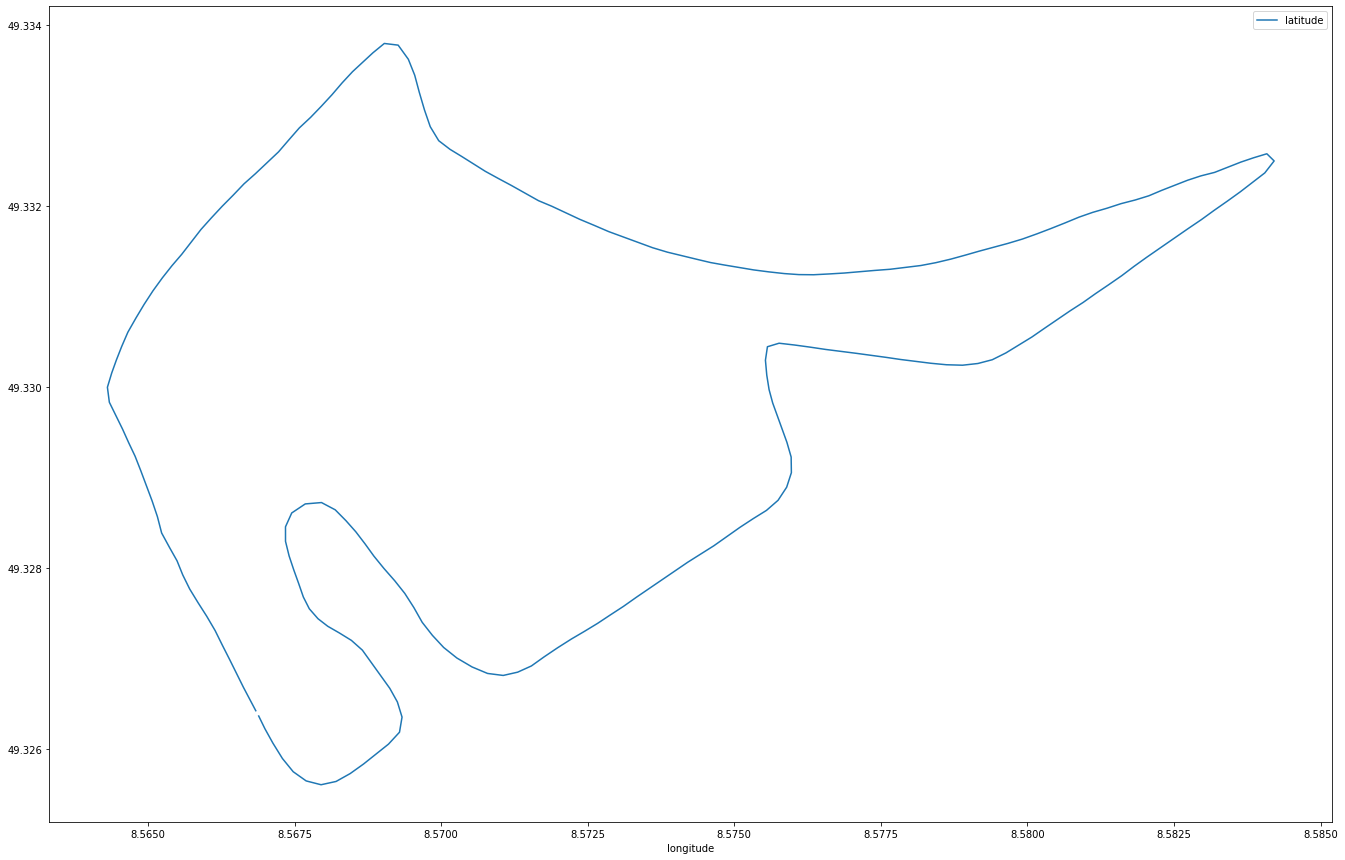

In [197]:
df_resample.plot(x='longitude', y='latitude', figsize=[23, 15])

## Export Processed GPX

In [198]:
# Creating a new file:
# --------------------

gpx_out = gpxpy.gpx.GPX()

gpx_out.name = 'Hockenheimring F1 Track - Smoothed V2'

# Create first track in our GPX:
gpx_track = gpxpy.gpx.GPXTrack()
gpx_out.tracks.append(gpx_track)

# Create first segment in our GPX track:
gpx_segment = gpxpy.gpx.GPXTrackSegment()
gpx_track.segments.append(gpx_segment)

# Create points:

#gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(x['latitude'], x['longitude'], elevation=x['ele_smoothed']))

df.apply(lambda x: gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(x['lat_savgol'], x['lon_savgol'], elevation=x['ele_savgol'])), axis=1)

#print('Created GPX:', gpx_out.to_xml())

print('Writing GPX file...')

gpx_file_out = open('hockenheimring-magic-road-processed.GPX', 'w')
gpx_file_out.write(gpx_out.to_xml())

="8.568450065458306">
        <ele>107.29325389189088</ele>
      </trkpt>
      <trkpt lat="49.328504988667774" lon="8.56841676785018">
        <ele>107.24963070405593</ele>
      </trkpt>
      <trkpt lat="49.328530958758336" lon="8.56838247160734">
        <ele>107.2054068113259</ele>
      </trkpt>
      <trkpt lat="49.32855630595467" lon="8.568346751982459">
        <ele>107.16373172627678</ele>
      </trkpt>
      <trkpt lat="49.328581118957224" lon="8.568309658560436">
        <ele>107.12180851330457</ele>
      </trkpt>
      <trkpt lat="49.32860481584996" lon="8.568270939113429">
        <ele>107.08278074021837</ele>
      </trkpt>
      <trkpt lat="49.32862721287329" lon="8.568230683176859">
        <ele>107.04384564567778</ele>
      </trkpt>
      <trkpt lat="49.32864808824401" lon="8.568188752336924">
        <ele>107.00814097175551</ele>
      </trkpt>
      <trkpt lat="49.32866697039172" lon="8.568144765072518">
        <ele>106.97568419610526</ele>
      </trkpt>
     

136000